In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt # 학습과정 loss와 acc 시각화
# quiz에서는 scale조정, train_test_split 등을 추가
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model

- Red Wine 등급 예측

```
1. 데이터 셋 확보 및 전처리
    csv -> 결측치 처리 -> 독립변수와 타겟변수 분리 -> 독립변수 스케일조정,
    -> 타겟변수의 원핫인코딩 -> 훈련셋과 테스트셋분리(train_test_split이용 층화추출)
2. 모델 구성(입력11, 출력6-get_dummies | 출력9-to_categorical) layer층 4
3. 모델 학습 과정 설정
4. 모델학습(callbacks이용)
5. 모델 평가(그래프, 평가, 교차표)
6. 모델저장 & 사용
```

# 1. 데이터 확보 & 전처리

In [3]:
# 데이터 읽어오기
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
# 결측치 확인
print('결측치 확인\n',redwine.isna().sum())
# 독립변수와 타겟변수 분리
redwine_X = redwine.iloc[:,:-1].to_numpy() # .values와 유사
redwine_y = redwine.iloc[:,-1]
print('타겟변수가 될 와인 등급 종류 : ', redwine_y.unique()) # 3,4,5,6,7,8 
print('등급별 데이터 수 :\n', redwine_y.value_counts()) # 3과 8은 데이터 수가 적어 못 맞출 듯

# 독립변수 scale 조정
scaler = StandardScaler()
scaler.fit(redwine_X)
scaled_X_redwine = scaler.transform(redwine_X)

# 타겟변수 원핫인코딩 후 numpy 배열로 변환
Y_redwine = pd.get_dummies(redwine_y).values # to_numpy()와 유사 0 0 0 0 0 1
# Y_redwine = to_categorical(redwine_y) 0 0 0 0 0 0 0 0 1
Y_redwine

# 훈련셋과 테스트셋 분리 (7:3)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine,
                                                   Y_redwine,
                                                   test_size=0.3, # 테스트셋비율
                                                   random_state=7,
                                                   stratify=Y_redwine) # 층화추출                                                   
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

결측치 확인
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
타겟변수가 될 와인 등급 종류 :  [5 6 7 4 8 3]
등급별 데이터 수 :
 5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
(1119, 11) (1119, 6) (480, 11) (480, 6)


In [4]:
# 층화추출을 하면 등급별 7:3으로  shuffle 되서 추출
print('train, test, all')
print(
np.c_[pd.Series(Y_train.argmax(axis=1)).value_counts(),
      pd.Series(Y_test.argmax(axis=1)).value_counts(),
     redwine_y.value_counts()]
)

train, test, all
[[477 204 681]
 [446 192 638]
 [139  60 199]
 [ 37  16  53]
 [ 13   5  18]
 [  7   3  10]]


# 2. 모델 구성(입력11, 출력6) layer층 4

In [5]:
# 2. 모델 구성하기
model = Sequential()
model.add(Input(shape=(11,))) # 의미있는 레이어가 아니고 input_dim만 지정
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=30, activation="relu"))
model.add(Dense(units=6, activation="softmax")) # 3 4 5 6 7 8 등급의 결과 합이 1
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1950      
                                                                 
 dense_3 (Dense)             (None, 6)                 186       
                                                                 
Total params: 11,928
Trainable params: 11,928
Non-traina

# 3. 모델 학습 과정 설정

In [6]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# 4. 모델학습(callbacks이용)

In [7]:
%%time

class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self): # 생성자 함수
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%5 ==0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.\
                 format(self.epoch, 
                        logs.get('loss'), 
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))
model_save_folder = './model/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-val{val_accuracy:.4f}.h5'
# 모델 자동저장 콜백
checkpoint = ModelCheckpoint(filepath=file,          # 저장경로
                             monitor='val_accuracy', # 모니터링할 지표 'loss', 'accuracy', 'val_loss' 등
                            save_best_only=True,     # 모니터링 지표가 개선된 경우만 저장. False로 하면 매번 에포크마다 저장
                            mode='max',         # 값이 클수록 좋을 때, 'min'은 값이 작을수록 좋을 때. auto도 있음
                            verbose=1)            # 저장 시 로그 출력 (1: 저장시 메세지 출력, 0: 출력 안 함)
customHistory = CustomHistory()
earlyStropping = EarlyStopping(patience=20)
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200, 
                 validation_split=0.2, 
                 callbacks=[earlyStropping, 
                           customHistory,
                           checkpoint],
                verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.39286, saving model to ./model\wine-001-val0.3929.h5

Epoch 2: val_accuracy improved from 0.39286 to 0.56696, saving model to ./model\wine-002-val0.5670.h5

Epoch 3: val_accuracy did not improve from 0.56696

Epoch 4: val_accuracy did not improve from 0.56696
epoch:5, loss:1.2814172506332397, acc:0.54078209400177, val_loss:1.230356216430664, val_acc:0.5669642686843872

Epoch 5: val_accuracy did not improve from 0.56696

Epoch 6: val_accuracy improved from 0.56696 to 0.57143, saving model to ./model\wine-006-val0.5714.h5

Epoch 7: val_accuracy improved from 0.57143 to 0.57589, saving model to ./model\wine-007-val0.5759.h5

Epoch 8: val_accuracy improved from 0.57589 to 0.59821, saving model to ./model\wine-008-val0.5982.h5

Epoch 9: val_accuracy did not improve from 0.59821
epoch:10, loss:1.0638680458068848, acc:0.5698323845863342, val_loss:1.0501291751861572, val_acc:0.5892857313156128

Epoch 10: val_accuracy did not improve from 0.59821



# 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표(crosstab)

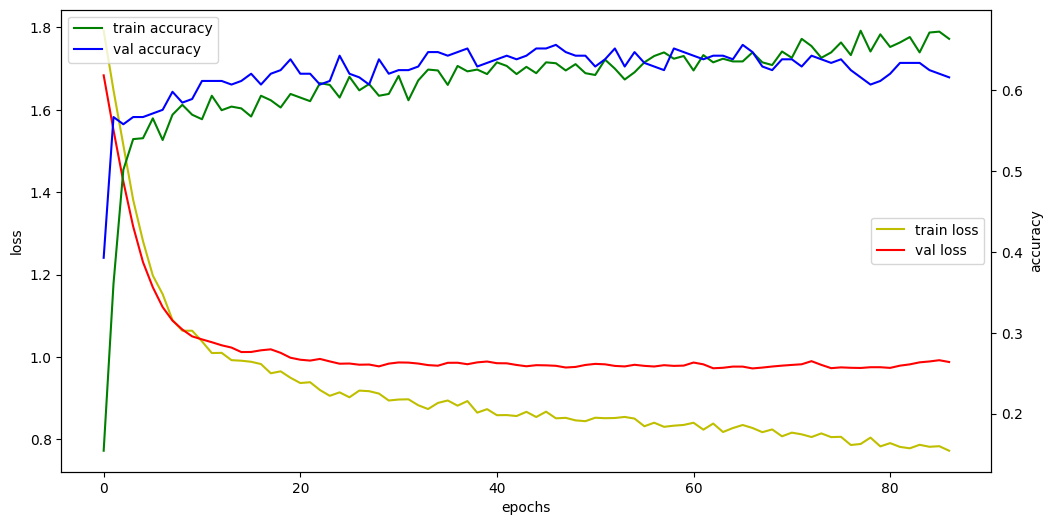

In [8]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [10]:
# 어떤 모델을 쓸지?
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
print('현 모델의 loss : ', loss_and_acc[0])
print('현 모델의 accuracy : ', loss_and_acc[1])
model2 = load_model('model/wine-047-val0.6562.h5')
loss_and_acc2 = model2.evaluate(X_test, Y_test, batch_size=32, verbose=0)
print('저장된 모델 중 best모델 loss : ', loss_and_acc2[0])
print('저장된 모델 중 best모델 accuracy : ', loss_and_acc2[1])

현 모델의 loss :  1.0057735443115234
현 모델의 accuracy :  0.6104166507720947
저장된 모델 중 best모델 loss :  1.0274364948272705
저장된 모델 중 best모델 accuracy :  0.6104166507720947


In [11]:
# 성능 지표(crosstab)
# Y_test : 0 0 1 0 0 0 (3등급, 4등급, 5등급, 6등급, 7등급, 8등급)
y = np.argmax(Y_test, axis=1) +3 # Y_test의 실제값(pd.getdummies)
yhat = model.predict(X_test).argmax(axis=1)+3 # 예측값
pd.crosstab(y, yhat, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 643us/step


predict,4,5,6,7
real,,,,
3,1,2,0,0
4,0,12,3,1
5,1,155,45,3
6,0,60,106,26
7,0,7,21,32
8,0,0,3,2


In [12]:
# 6. 모델 사용하기
input_data = np.array([7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4])
scaled_data = scaler.transform(input_data.reshape(1,11))
print(np.argmax(model.predict(scaled_data), axis=1) + 3, '등급으로 예측함')

1/1 [==============================] - 0s 45ms/step
[5] 등급으로 예측함
